In [54]:
#############################################################
#                                                           #
#                                                           #
#                                                           #
#############################################################

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state

In [55]:
#4.2. Regressão  
# Considere apenas os países Southern Europe:

df = pd.read_csv("AIRPOL_data.csv", delimiter=";", usecols=range(8))

print(df.dtypes)

Country                         object
NUTS_Code                       object
Air_Pollutant                   object
Outcome                         object
Affected_Population             object
Populated_Area[km2]             object
Air_Pollution_Average[ug/m3]    object
Value                           object
dtype: object


In [56]:
# Convert columns to numeric
df['Value'] = df['Value'].str.replace(',', '.').astype(float)
df['Air_Pollution_Average[ug/m3]'] = df['Air_Pollution_Average[ug/m3]'].str.replace(',', '.').astype(float)
df['Populated_Area[km2]'] = df['Populated_Area[km2]'].str.replace(',', '.').astype(float)
df['Affected_Population'] = df['Affected_Population'].str.replace(',', '.').astype(float)

selected_countries = ["Greece", "Spain", "Italy", "Portugal"]
southern_europe = df[df["Country"].isin(selected_countries)]

southern_europe.head()

,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
1274,Greece,EL643,PM2.5,Chronic obstructive pulmonary disease,15469.0,243.2,7.6,0.0
1548,Portugal,PT16H,PM2.5,Chronic obstructive pulmonary disease,67529.0,1098.3,5.8,0.0
1552,Spain,ES417,PM2.5,Chronic obstructive pulmonary disease,72931.0,610.6,5.2,0.0
3094,Greece,EL412,PM2.5,Chronic obstructive pulmonary disease,26702.0,232.2,9.0,1.0
3096,Greece,EL621,PM2.5,Chronic obstructive pulmonary disease,27037.0,184.4,9.2,1.0


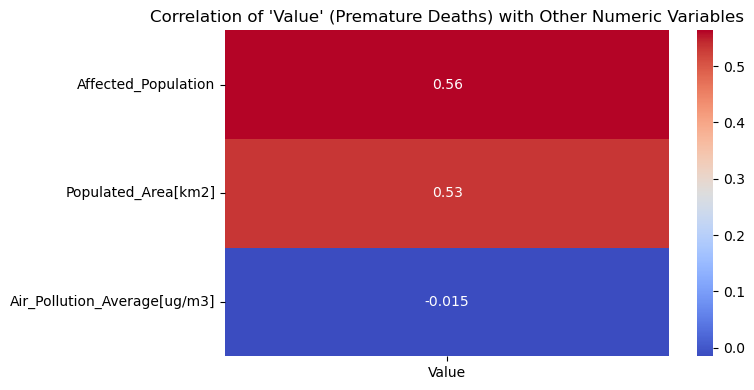

In [57]:
# 1 - Crie um diagrama de correlação entre a variável Premature_Deaths e os restantes atributos e interprete.

# Select only numeric columns
numeric_df = southern_europe.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Focus only on correlation with 'Value'
value_corr = corr_matrix['Value'].drop('Value')  # Drop self-correlation

# Plot
plt.figure(figsize=(8, 4))
sns.heatmap(value_corr.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation of 'Value' (Premature Deaths) with Other Numeric Variables")
plt.tight_layout()
plt.show()


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 2 - Usando o método k-fold cross validation obtenha um modelo regressão linear simples para a variável Premature_Deaths usando a variável 
# Affected_Population.

X = southern_europe[['Affected_Population']] #independent
y = southern_europe[['Value']] # dependent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred_test = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

In [59]:
# a) Apresente a função linear resultante 

print("y=", regressor.intercept_, "+", regressor.coef_, "x")

y= [-13.04972974] + [[0.00037836]] x


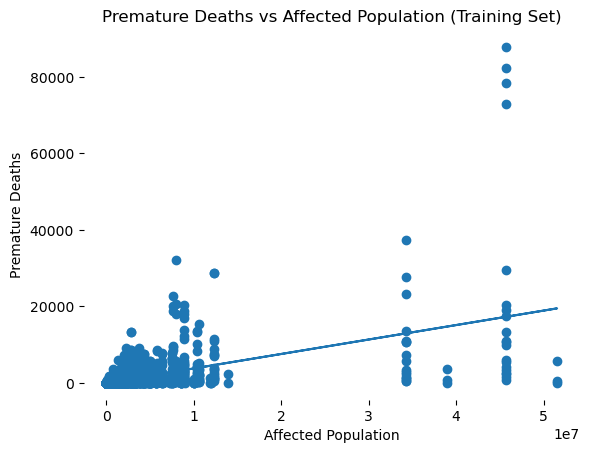

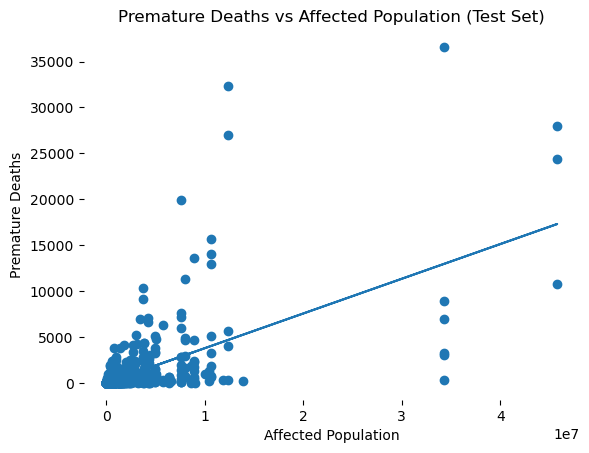

In [60]:
# b) Visualize a reta correspondente ao modelo de regressão linear simples e o respetivo diagrama de dispersão. 

# Train set predictions results
plt.scatter(X_train, y_train)
plt.plot(X_train, y_pred_train)
plt.title("Premature Deaths vs Affected Population (Training Set)")
plt.xlabel("Affected Population")
plt.ylabel("Premature Deaths")
plt.box(False)
plt.show()

# Test set predictions results
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred_test)
plt.title("Premature Deaths vs Affected Population (Test Set)")
plt.xlabel("Affected Population")
plt.ylabel("Premature Deaths")
plt.box(False)
plt.show()

In [61]:
# c) Calcule o erro médio absoluto (MAE) e raiz quadrada do erro médio (RMSE) do modelo

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = regressor.predict(X_test)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("MAE on testing set: {:.3f}".format(MAE))
print("RMSE on testing set: {:.3f}".format(RMSE))

MAE on testing set: 400.133
RMSE on testing set: 1513.205


In [62]:
# 3 - Usando o método k-fold cross validation desenvolva modelos para prever Premature_Deaths usando:
# a) Regressão linear múltipla.

In [ ]:
# Árvore de regressão. Otimize os parâmetros do modelo. Apresente a árvore de regressão obtida.

from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_Size = 0.2, random_state = 42)
tree = DecisionTreeRegressor(random_state = 42, max_depth = 6, min_samples_split = 3)

model = tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

MAE = metrics.mean_absolute_error(y_test, y_pred)

print("MAE on test set: {:.3f}".format(MAE))

# Visualization

from sklearn import tree

tree.plot_tree(model, feature_names = list(southern_europe.columns), class_names = list)